# Advanced Machine Learning
## Project 2 - Deep Reinforcement Learning

Faculty: Helena Aidos

### Introduction

"Mountain Car is a classic reinforcement learning problem, often used as a benchmark for testing the performance of reinforcement learning algorithms. In this problem, an underpowered car must climb a steep hill to reach a goal located at the top of the hill. The car is subject to the laws of physics, which means that it cannot simply drive straight up the hill. Instead, it must build up speed by accelerating back and forth across the hill.

The state of the Mountain Car environment is represented by two continuous variables, the position and velocity of the car. The goal of the agent is to learn how to control the car's acceleration to climb the hill and reach the goal as quickly as possible while using the least amount of energy. The agent receives a negative reward for every step it takes to reach the goal, so the goal is to minimise the number of steps required to reach the goal."



### 1. Train the Q-learning agent

The main goal of this notebook is to implement three agents to solve the Mountain Car problem: the Q-learning and two deep learning agents (using deep Q-network and soft actor-critic, implemented in a JAX package). For that we will use the `Gymnasium` environment version. We will also be tuning the parameters for the deep learning agents and training the Q learning agent. 

In [78]:
!pip install gymnasium gymnasium[toy-text]

Defaulting to user installation because normal site-packages is not writeable


We will be using the `seaborn` library for visualizations.
```python
!pip install seaborn
```

#### 1.1 Creating the environment

In [81]:
import gymnasium as gym

We will now create the Mountain Car environment. 

In [83]:
env = gym.make('MountainCar-v0')

#### 1.2. Discretizing the observation space

We have learned that the reinforcement learning environment can be modelled as a Markov decision process (MDP), and an MDP consists of the following:

* **States** - A set of states present in the environment. A state space consists of all of our states. We can obtain the number of states in our environment by just typing `env.observation_space`
* **Actions** - A set of actions the agent can perform in each state.
* **Reward function** - Reward function is denoted by $R(s,a,s')$. It implies the reward the agent obtains moving from a state $s$ to the state $s'$ while performing an action $a$.



In [86]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

The action space consists of all the possible actions in the environment. We can obtain the action space by `env.action_space` as shown below:

In [88]:
import numpy as np

position_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=20)
velocity_bins = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=20)

def discretize_state(state):
    position, velocity = state
    position_idx = np.digitize(position, position_bins) - 1
    velocity_idx = np.digitize(velocity, velocity_bins) - 1
    return (position_idx, velocity_idx)

In [89]:
env.action_space

Discrete(3)

In [90]:
env.action_space.n

3

In the mountain car we have 3 discrete states in our state space: accelerating, deaccelerating and static. These states will be encoded as a number, from 0 to 2.

#### 1.3 Implementing Epsilon-Greedy

Let's define the dictionary for storing the Q value of the state-action pair, and we initialize the Q value of all the state-action pair to 0.0:

In [94]:
Q = np.zeros(((len(position_bins), len(velocity_bins), env.action_space.n)))

print(Q)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


Now, let's define the epsilon-greedy policy. We generate a random number from the uniform distribution and if the random number is less than epsilon we select the random action else we select the best action which has the maximum Q value:

In [96]:
import random
import numpy as np

def epsilon_greedy(state, epsilon):
    #seed(1)
    r = random.random()
    
    if r < epsilon:
        #a= env.unwrapped.P[random()][random()]
        return random.choice(range(env.action_space.n))
    else:
        return np.argmax(Q[state])

epsilon_greedy(1,0.1)

0

#### 1.4 Implementing the Q-learning algorithm

Initialize the discount factor $\gamma$ and the learning rate $\alpha$ and epsilon value. Set the number of episodes and number of time steps in the episode.

In [99]:
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01
num_episodes = 5000
rewards = []

Compute the optimal policy using the Q learning update rule as:

$Q(s,a) = Q(s,a) + \alpha (r + \gamma \max_{a'} Q(s',a') - Q(s,a))$

In [101]:
#for each episode:
for episode in range(num_episodes):
    state = discretize_state(env.reset()[0])
    total_reward = 0

    for step in range(200):
        action = epsilon_greedy(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        next_state = discretize_state(next_state)

        # Q-learning update
        best_next_action = np.argmax(Q[next_state])
        Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])

        state = next_state
        total_reward += reward
        if done:
            break

    rewards.append(total_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    if episode % 100 == 0:
        print(f"Episode {episode}, Reward: {total_reward}")

Episode 0, Reward: -200.0
Episode 100, Reward: -200.0
Episode 200, Reward: -200.0
Episode 300, Reward: -200.0
Episode 400, Reward: -200.0
Episode 500, Reward: -200.0
Episode 600, Reward: -200.0
Episode 700, Reward: -200.0
Episode 800, Reward: -200.0
Episode 900, Reward: -200.0
Episode 1000, Reward: -200.0
Episode 1100, Reward: -200.0
Episode 1200, Reward: -200.0
Episode 1300, Reward: -200.0
Episode 1400, Reward: -199.0
Episode 1500, Reward: -200.0
Episode 1600, Reward: -200.0
Episode 1700, Reward: -200.0
Episode 1800, Reward: -200.0
Episode 1900, Reward: -165.0
Episode 2000, Reward: -112.0
Episode 2100, Reward: -200.0
Episode 2200, Reward: -200.0
Episode 2300, Reward: -200.0
Episode 2400, Reward: -200.0
Episode 2500, Reward: -200.0
Episode 2600, Reward: -200.0
Episode 2700, Reward: -153.0
Episode 2800, Reward: -193.0
Episode 2900, Reward: -168.0
Episode 3000, Reward: -200.0
Episode 3100, Reward: -156.0
Episode 3200, Reward: -200.0
Episode 3300, Reward: -200.0
Episode 3400, Reward: -145

#### 1.5 Validating the agent measure

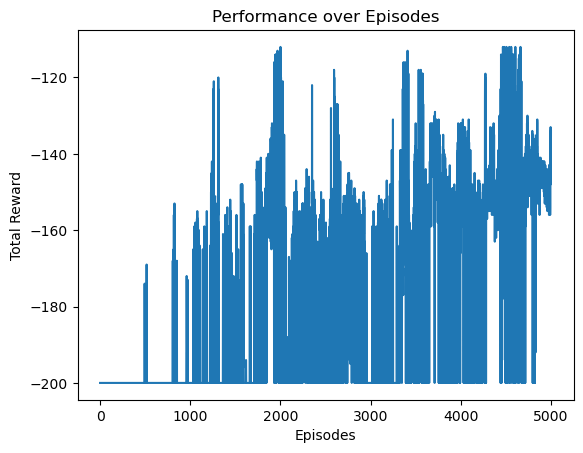

In [103]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Performance over Episodes')
plt.show()